# Imports

In [43]:
%load_ext autoreload
%autoreload 2

#import viewdat_cno_lib as vdl
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import subprocess
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [44]:
def pos_read(fname_tsv, header_n_rows=159):
    if not os.path.isfile(fname_tsv):
        print(f"Unable to find {fname_tsv}")
        return None
    # Import the data into a Pandas DataFrame, and do some cleanup
    df = pd.read_csv(fname_tsv, delimiter='\t', header=header_n_rows, na_values=['Nan'])
    df.rename(columns=lambda x: x.strip(), inplace=True)  # drop whitespace
    df = df.replace({'Nan': np.nan})
    #print(list(df.columns))
    cols_rename = {
        '%Week': 'Week',
        # 'TRACK': 'Track',
    }
    df.rename(columns=cols_rename, inplace=True)
    #df = week_rollover_unwrap(df)
    return df

In [45]:
# This class was brazenly stolen from mutils.py in the Sunnyvale CVS repo
class OrbitConst(object):
    """
    Orbital constants
    """
    PI = 3.14159265358979323846
    A_WGS84 = 6378137.0
    B_WGS84 = 6356752.314245179
    E2_WGS84 = 6.69437999013e-3
    ONE_MIN_E2 = 0.99330562000987
    SQRT_ONE_MIN_E2 = 9.96647189335258e-1
    

# This function was brazenly stolen from mutils.py in the Sunnyvale CVS repo
def llh2enu(llh, ref_llh, is_rad=False, is_ref_rad=False):
    """
    Convert lat/lon/height to delta east/north/up.
    llh = array of lat/lon/height [lat/lon in degrees by default]
    ref_llh = point or array of lat/lon/height [lat/lon in degrees by default]
    is_rad = True -> "llh" lat/lon is radians, else in degrees
    is_ref_rad = True -> "ref_llh" lat/lon is radians, else in degrees
    """
    # Make sure inputs are arrays
    if len(np.shape(llh)) == 1:
        llh = llh.reshape((1, len(llh)))
    if len(np.shape(ref_llh)) == 1:
        ref_llh = ref_llh.reshape((1, len(ref_llh)))

    # Convert to radians?
    scale1 = np.ones(np.shape(llh))
    scale2 = np.ones(np.shape(ref_llh))
    ref_lat = np.copy(ref_llh[:, 0])
    if not is_rad:
        scale1[:, 0:2] *= OrbitConst.PI/180
    if not is_ref_rad:
        scale2[:, 0:2] *= OrbitConst.PI/180
        ref_lat *= OrbitConst.PI/180

    # Compute the residuals
    dllh = llh*scale1 - ref_llh*scale2

    # Compute Radii of Curvature
    W = np.sqrt(1 - OrbitConst.E2_WGS84 * np.sin(ref_lat)**2)
    N = OrbitConst.A_WGS84 / W
    M = OrbitConst.A_WGS84 * (1 - OrbitConst.E2_WGS84) / W**3

    # Compute Metric Components
    dE = dllh[:, 1] * N * np.cos(ref_lat)
    dN = dllh[:, 0] * M
    dU = dllh[:, 2]

    return (dE, dN, dU)

In [46]:
def calc_heading(lat1, long1, lat2, long2):
    rlat1 = math.radians(lat1)
    rlat2 = math.radians(lat2)
    rlon1 = math.radians(long1)
    rlon2 = math.radians(long2)
    dLon = rlon2 - rlon1
    x = math.cos(rlat2) * math.sin(dLon)
    y = math.cos(rlat1) * math.sin(rlat2)
    y -= math.sin(rlat1) * math.cos(rlat2) * math.cos(dLon)
    heading = np.arctan2(x, y)
    heading = math.degrees(heading)
    heading = (heading + 180.0) % 360.0   # convert from -180:+180 to 0:360
    return heading

In [47]:
def dms_to_dd(d:float, m:float, s:float):
    dd = d + float(m)/60 + float(s)/3600
    if d<0:
        dd = float(d) - float(m)/60 - float(s)/3600
    else:
        dd = float(d) + float(m)/60 + float(s)/3600
    return dd

In [48]:
def plot_neu(df, title, fname=None):
    ne_lim = np.max([df["E"].abs().max(), df["N"].abs().max(),
                      df["vE"].abs().max(), df["vN"].abs().max(),
                     ])
    
    fix, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
    
    ax0.plot(df.E, df.N, '+')
    ax0.plot(0, 0, 'ro')
    ax0.plot(df.vE, df.vN, 'cx')
    ax0.set_xlabel('Easting')
    ax0.set_ylabel('Northing')
    ax0.set_title('Horizontal')
    ax0.legend(['Primary', 'Reference', 'Vector'])
    
    ax0.axis('square')
    ax0.set_xlim([-ne_lim, ne_lim])
    ax0.set_ylim([-ne_lim, ne_lim])

    print(f'Easting spread:  {df.E.max()-df.E.min():0.3f}m')
    print(f'Northing spread: {df.N.max()-df.N.min():-.3f}m')
    
    ax1.plot(df.E, df.U, '+')
    ax1.plot(0, 0, 'ro')
    ax1.plot(df.vE, df.vU, 'cx')
    ax1.set_xlabel('Easting')
    ax1.set_ylabel('Upping')
    ax1.set_title('Vertical')
    ax1.legend(['Primary', 'Reference', 'Vector'])
    
    #ax1.axis('square')
    ax1.set_xlim([-ne_lim, ne_lim])
    #ax1.set_ylim([-ne_lim_1910, ne_lim_1910])
    plt.suptitle(title)
    print(f'Upping spread: {df1910.U.max()-df1910.U.min():-.3f}m')
    
    if fname is not None:
        plt.savefig(fname)

# Reference
The following from [Judo moving base smoke test](https://docs.google.com/document/d/1emg9laypkMTw59sw85Z98evTwy1eW84I/edit?usp=sharing&ouid=103901858714909842793&rtpof=true&sd=true)\
Moving base judo was on B1 = 39&deg;53'45.53852", 105&deg;06'48.39732, 1644.897\
Vector judo was on B2 = 39&deg;53'45.51493", 105&deg;06'48.31353, 1644.906\
Length between B1 and B2 = 2.119m\
Azimuth from B1 to B2 109.8284126&deg;

In [49]:
B1_Lat = dms_to_dd(39, 53, 45.53852)
B1_Lon = dms_to_dd(-105, 6, 48.39732)
B1_Hgt = 1644.897
B1_llh = np.array([B1_Lat, B1_Lon, B1_Hgt])
print(f'{B1_llh=}')

B2_Lat = dms_to_dd(39, 53, 45.51493)
B2_Lon = dms_to_dd(-105, 6, 48.31353)
B2_Hgt = 1644.906
B2_llh = np.array([B2_Lat, B2_Lon, B2_Hgt])
print(f'{B2_llh=}')

dE, dN, dU = llh2enu(B1_llh, B2_llh)
print(np.sqrt(dE**2 + dN**2), dU)

heading = calc_heading(B2_Lat, B2_Lon, B1_Lat, B1_Lon)
print(heading)

B1_llh=array([  39.89598292, -105.1134437 , 1644.897     ])
B2_llh=array([  39.89597637, -105.11342043, 1644.906     ])
[2.11935585] [-0.009]
110.15123875774027


# Data 06-12

## B2 (6348C01835)

In [50]:
cmd = 'viewdat -d35:2 --t04_vector_position -mb -h 0612/6348C01835*.T04 -o0612/6348C01835.tsv'.replace(' ', ',').split(',')
print(f'{cmd=}')
subprocess.run(cmd)
df1835 = pos_read('0612/6348c01835.tsv', 159) #102)
df1835[['MLat', 'MLon', 'MHgt', 'MvLat', 'MvLon', 'MvHgt','Pos2Lat', 'Pos2Lon', 'Pos2Hgt']].mean()

cmd=['viewdat', '-d35:2', '--t04_vector_position', '-mb', '-h', '0612/6348C01835*.T04', '-o0612/6348C01835.tsv']


MLat         39.895977
MLon       -105.113422
MHgt       1645.119866
MvLat         0.000011
MvLon         0.001479
MvHgt         0.003882
Pos2Lat            NaN
Pos2Lon            NaN
Pos2Hgt            NaN
dtype: float64

In [51]:
Judo1835_llh = np.array(df1835[['MLat', 'MLon', 'MHgt']].mean())
print(Judo1835_llh)

[  39.8959772  -105.11342238 1645.1198662 ]


## B1 (6348C01910)

In [52]:
cmd = 'viewdat -d35:2 --t04_vector_position -mb -h 0612/6348C01910*.T04 -o0612/6348C01910.tsv'.replace(' ', ',').split(',')
print(f'{cmd=}')
subprocess.run(cmd)
df1910 = pos_read('0612/6348c01910.tsv', 159) #102)
#df1910[['MLat', 'MLon', 'MHgt', 'MvLat', 'MvLon', 'MvHgt','Pos2Lat', 'Pos2Lon', 'Pos2Hgt']].mean()
Judo1910_llh = np.array(df1910[['MLat', 'MLon', 'MHgt']].mean())
print(Judo1910_llh)

cmd=['viewdat', '-d35:2', '--t04_vector_position', '-mb', '-h', '0612/6348C01910*.T04', '-o0612/6348C01910.tsv']
[  39.89598437 -105.11344561 1645.11030185]


In [53]:
dE, dN, dU = llh2enu(Judo1835_llh, Judo1910_llh)
print(np.sqrt(dE**2 + dN**2), dU)

heading = calc_heading(Judo1910_llh[0], Judo1910_llh[1], Judo1835_llh[0], Judo1835_llh[1])
print(heading)

[2.14009197] [0.00956436]
291.8998301485318


## Calc Northings, Eastings, Up

In [54]:
dE, dN, dU = llh2enu(np.array(df1835[['MLat', 'MLon', 'MHgt']]), B2_llh)
df1835['E'] = dE
df1835['N'] = dN
df1835['U'] = dU

vdE, vdN, vdU = llh2enu(np.array(df1835[['VLat', 'VLon', 'VHgt']]), B2_llh)
df1835['vE'] = vdE
df1835['vN'] = vdN
df1835['vU'] = vdU

In [55]:
dE, dN, dU = llh2enu(np.array(df1910[['MLat', 'MLon', 'MHgt']]), B1_llh)
df1910['E'] = dE
df1910['N'] = dN
df1910['U'] = dU

vdE, vdN, vdU = llh2enu(np.array(df1910[['VLat', 'VLon', 'VHgt']]), B1_llh)
df1910['vE'] = vdE
df1910['vN'] = vdN
df1910['vU'] = vdU

## Plots

Easting spread:  0.863m
Northing spread: 0.608m
Upping spread: 9.069m


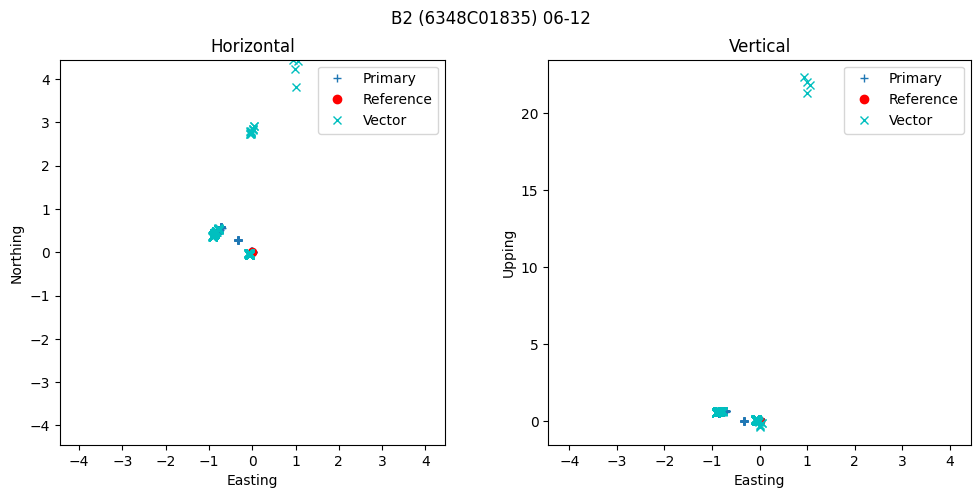

In [56]:
plot_neu(df1835, 'B2 (6348C01835) 06-12', '0612/B2_6348C01835.png')

Easting spread:  2.494m
Northing spread: 14.342m
Upping spread: 9.069m


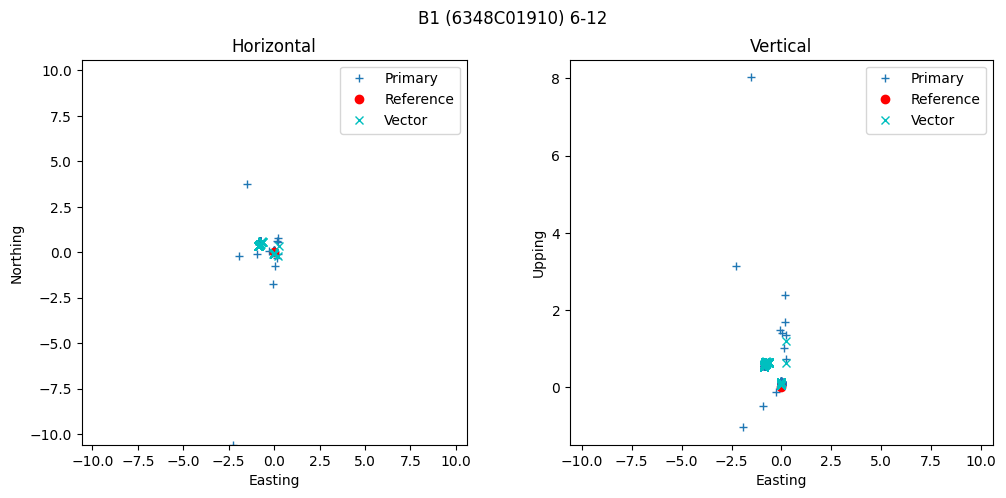

In [57]:
plot_neu(df1910, 'B1 (6348C01910) 6-12', '0612/B1_6348C01910.png')

# Data 06-14

## B2 (6348C01835)

In [58]:
cmd = 'viewdat -d35:2 --t04_vector_position -mb -h 0614/6348C01835*.T04 -o0614/6348C01835.tsv'.replace(' ', ',').split(',')
print(f'{cmd=}')
subprocess.run(cmd)
df1835 = pos_read('0614/6348c01835.tsv', 159) #102)
df1835[['MLat', 'MLon', 'MHgt', 'MvLat', 'MvLon', 'MvHgt','Pos2Lat', 'Pos2Lon', 'Pos2Hgt']].mean()

cmd=['viewdat', '-d35:2', '--t04_vector_position', '-mb', '-h', '0614/6348C01835*.T04', '-o0614/6348C01835.tsv']


MLat         39.895977
MLon       -105.113421
MHgt       1644.994333
MvLat        -0.000756
MvLon         0.000782
MvHgt         0.003041
Pos2Lat            NaN
Pos2Lon            NaN
Pos2Hgt            NaN
dtype: float64

In [59]:
Judo1835_llh = np.array(df1835[['MLat', 'MLon', 'MHgt']].mean())
print(Judo1835_llh)

[  39.89597656 -105.11342054 1644.99433339]


## B1 (6348C01910)

In [60]:
cmd = 'viewdat -d35:2 --t04_vector_position -mb -h 0614/6348C01910*.T04 -o0614/6348C01910.tsv'.replace(' ', ',').split(',')
print(f'{cmd=}')
subprocess.run(cmd)
df1910 = pos_read('0614/6348c01910.tsv', 159) #102)
#df1910[['MLat', 'MLon', 'MHgt', 'MvLat', 'MvLon', 'MvHgt','Pos2Lat', 'Pos2Lon', 'Pos2Hgt']].mean()
Judo1910_llh = np.array(df1910[['MLat', 'MLon', 'MHgt']].mean())
print(Judo1910_llh)

cmd=['viewdat', '-d35:2', '--t04_vector_position', '-mb', '-h', '0614/6348C01910*.T04', '-o0614/6348C01910.tsv']
[  39.89598379 -105.11344383 1644.97629956]


In [61]:
dE, dN, dU = llh2enu(Judo1835_llh, Judo1910_llh)
print(np.sqrt(dE**2 + dN**2), dU)

heading = calc_heading(Judo1910_llh[0], Judo1910_llh[1], Judo1835_llh[0], Judo1835_llh[1])
print(heading)

[2.14757487] [0.01803383]
292.03276180066945


## Calc Northings, Eastings, Up

In [62]:
dE, dN, dU = llh2enu(np.array(df1835[['MLat', 'MLon', 'MHgt']]), B2_llh)
df1835['E'] = dE
df1835['N'] = dN
df1835['U'] = dU

vdE, vdN, vdU = llh2enu(np.array(df1835[['VLat', 'VLon', 'VHgt']]), B2_llh)
df1835['vE'] = vdE
df1835['vN'] = vdN
df1835['vU'] = vdU

In [63]:
dE, dN, dU = llh2enu(np.array(df1910[['MLat', 'MLon', 'MHgt']]), B1_llh)
df1910['E'] = dE
df1910['N'] = dN
df1910['U'] = dU

vdE, vdN, vdU = llh2enu(np.array(df1910[['VLat', 'VLon', 'VHgt']]), B1_llh)
df1910['vE'] = vdE
df1910['vN'] = vdN
df1910['vU'] = vdU

## Plots

Easting spread:  0.075m
Northing spread: 0.065m
Upping spread: 0.147m


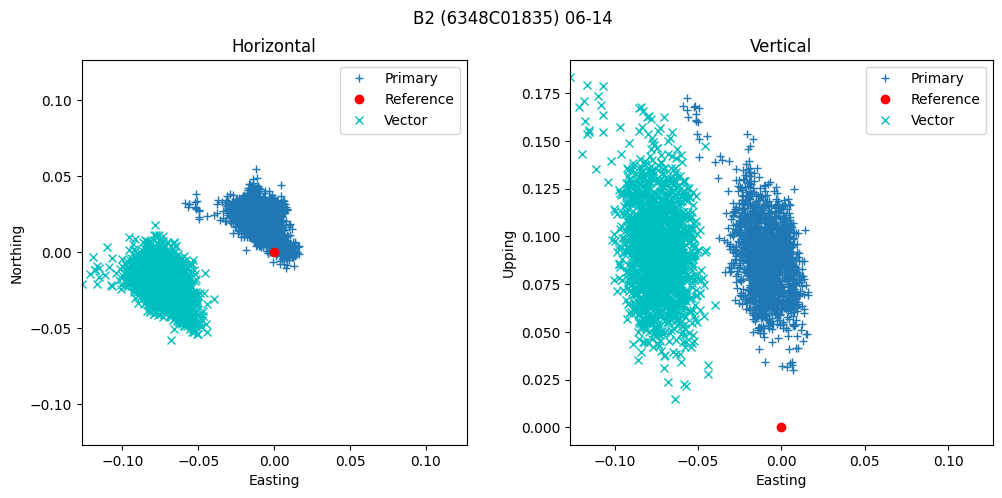

In [64]:
plot_neu(df1835, 'B2 (6348C01835) 06-14', '0614/B2_6348C01835.png')

Easting spread:  0.073m
Northing spread: 0.065m
Upping spread: 0.147m


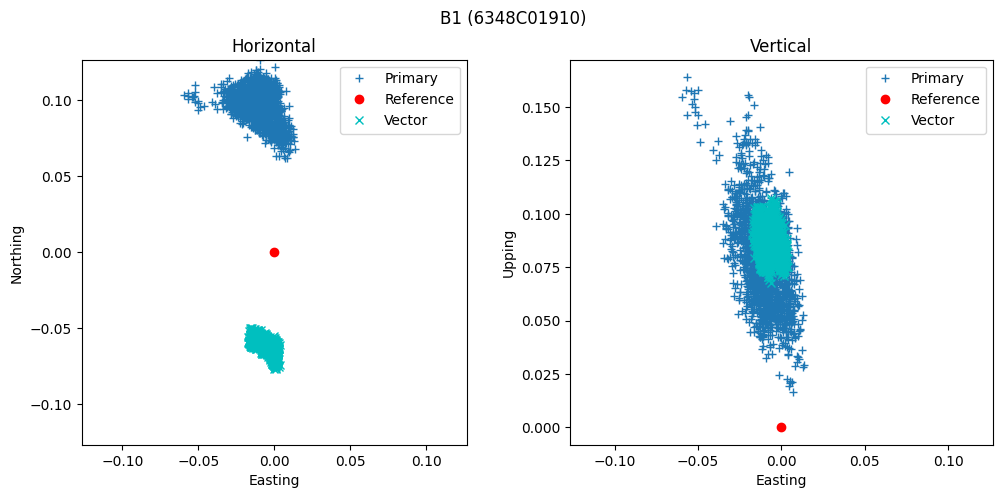

In [65]:
plot_neu(df1910, 'B1 (6348C01910)', '0614/B1_6348C01910.png')